# Summary of Preliminary Analysis

This notebook is for tempral work to think about what we shuold do in our actual analysis. First, we summarize the result of our preliminary analysis in the proposal.

In [1]:
import altair as alt
import numpy as np
np.random.seed(2023)
import pandas as pd
from sklearn.compose import make_column_transformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [2]:
# This cleaning-up procedure is mostly the same as our proposal
# We added some steps to omit rows containing unclassified values
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

original_data = pd.read_csv(url, names=[
    "age", 
    "sex", 
    "chest_pain", 
    "resting_blood_pressure", 
    "cholesterol", 
    "fasting_blood_sugar", 
    "resting_electrocardiographic_results", 
    "max_heart_rate",
    "exercise_induced_angina",  
    "st_depression_exercise", 
    "slope_st", 
    "major_vessels", 
    "thal",
    "diagnosis"
])

hd_data = original_data.dropna(how='all')

# omit rows containing unclassified values
hd_data = hd_data.drop(
    hd_data[hd_data.major_vessels == '?'].index
)
hd_data["major_vessels"] = pd.to_numeric(hd_data["major_vessels"])

hd_data = hd_data.drop(
    hd_data[hd_data.thal == '?'].index
)

In [3]:
# replace numeric values with categorical lables for categorical variables 
# except for 'resting_electrocardiographic_results' which requires a long description for each label
hd_data["sex"] = hd_data["sex"].apply(lambda x: "male" if (x == 1.0) else "female")

hd_data["chest_pain"] = hd_data["chest_pain"].replace({
    1: 'Typical angina',
    2: 'Atypical angina',
    3: 'Non-anginal pain',
    4: 'Asymptomatic'
})

hd_data["fasting_blood_sugar"] = hd_data["fasting_blood_sugar"].apply(lambda x: True if (x == 1.0) else False)

hd_data["exercise_induced_angina"] = hd_data["exercise_induced_angina"].apply(lambda x: 'Yes' if (x == 1.0) else 'No')

hd_data["slope_st"] = hd_data["slope_st"].replace({
    1.0: 'Upsloping',
    2.0: 'Flat',
    3.0: 'Downsloping'
})

hd_data["thal"] = hd_data["thal"].replace({
    '3.0': 'Normal',
    '6.0': 'Fixed defect',
    '7.0': 'Rreversable defect'
})


In [4]:
# define a column, 'heart_disease', based on the 'diagnosis' column and drop 'diagnosis'
hd_data["heart_disease"] = hd_data["diagnosis"].apply(
    lambda x: "undiagnosed" if (x == 0) else "diagnosed")
hd_data = hd_data.drop(columns=["diagnosis"])

hd_data.head()

,age,sex,chest_pain,resting_blood_pressure,cholesterol,fasting_blood_sugar,resting_electrocardiographic_results,max_heart_rate,exercise_induced_angina,st_depression_exercise,slope_st,major_vessels,thal,heart_disease
0,63.0,male,Typical angina,145.0,233.0,True,2.0,150.0,No,2.3,Downsloping,0.0,Fixed defect,undiagnosed
1,67.0,male,Asymptomatic,160.0,286.0,False,2.0,108.0,Yes,1.5,Flat,3.0,Normal,diagnosed
2,67.0,male,Asymptomatic,120.0,229.0,False,2.0,129.0,Yes,2.6,Flat,2.0,Rreversable defect,diagnosed
3,37.0,male,Non-anginal pain,130.0,250.0,False,0.0,187.0,No,3.5,Downsloping,0.0,Normal,undiagnosed
4,41.0,female,Atypical angina,130.0,204.0,False,2.0,172.0,No,1.4,Upsloping,0.0,Normal,undiagnosed


Now we have a 14-column dataset that contains six numerical variables and eight categorical variables. We will show the summary of the culumns in the foolowing table with the possibility of correlation which we determined in our preliminary analysis.

| # | Variable | Description | Value | Possible Correlation |
|---|----------|-------------|-------|----------------------|
| 1 | age | Individual's age | numerical | Yes |
| 2 | sex | Individual's sex | male or female | Yes |
| 3 | chest_pain | Chest pain type | Typical angina, Atypical angina, Non-anginal pain, or Asymptomatic | Yes |
| 4 | resting_blood_pressure | Resting blood pressure (in mm Hg on admission to the hospital) | numerical | worth checking again (See the below Note 1) |
| 5 | cholesterol | Serum cholestoral in mg/dL | numerical | need re-analysis (See the below Note 2) |
| 6 | fasting_blood_sugar | Fasting blood sugar > 120 mg/dL | True or False | No |
| 7 | resting_electrocardiographic_results | Resting electrocardiographic results | <ul><li>0: normal</li><li>1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)</li><li>2: showing probable or definite left ventricular hypertrophy by Estes' criteria</li></ul> | No |
| 8 | max_heart_rate | Maximum heart rate achieved | numerical | Yes |
| 9 | exercise_induced_angina | Exercise induced angina | Yes or No | Yes |
| 10 | st_depression_exercise | ST depression induced by exercise relative to rest | numerical | Yes |
| 11 | slope_st | The slope of the peak exercise ST segment | Upsloping, Flat, or Downsloping | Yes (but too technical) |
| 12 | major_vessels | Number of major vessels (0-3) colored by flourosopy | numerical | Yes |
| 13 | thal | Thalassemia | Normal, Fixed defect, or Reversable defect | Yes |
| 14 | heart_disease | Diagnosis of presence of heart disease | diagnosed or undiagnosed | NA |

Note 1: For `resting_blood_pressure`, we concluded the variable does not seem to have correlation with heart disease diganosis. However, it seems a pattern in the visualization; the samples diagnosed to heart disease seem to have higher blood pressure. So, we might consider including this variable into our analysis.

Note 2: For `cholesterol`, our preliminary analysis was not correctly done. As the later part of scaling and centering will show, the mean value of the serum cholesterol is about 246 mg/dL. Compared to this value, the visualization in our proposal does not seem to properly represent the observations of this variable. So, we may redo the analysis before actual analysis.

## Data Analysis

### Training Data and Test Data

We will obtain a training data and a test data from the data that we have cleaned-up and use only *the training data*, `hd_train`, from now on. We will stratify the target column `heart_disease` to preserve the class proportion.

In [5]:
hd_train, hd_test = train_test_split(hd_data, test_size=0.25, stratify=hd_data["heart_disease"])
print(hd_train["heart_disease"].value_counts(normalize=True))
print(hd_test["heart_disease"].value_counts(normalize=True))

undiagnosed    0.540541
diagnosed      0.459459
Name: heart_disease, dtype: float64
undiagnosed    0.533333
diagnosed      0.466667
Name: heart_disease, dtype: float64


We will check some statistics for all six numeric variables in our training data, `hd_train`.

In [6]:
age_stat = hd_train.agg({'age': ['mean', 'median', 'min', 'max']}).round(decimals=1)
rbp_stat = hd_train.agg({'resting_blood_pressure': ['mean', 'median', 'min', 'max']}).round(decimals=2)
chol_stat = hd_train.agg({'cholesterol': ['mean', 'median', 'min', 'max']}).round(decimals=2)
max_hr_stat = hd_train.agg({'max_heart_rate': ['mean', 'median', 'min', 'max']}).round(decimals=2)
st_depression_exercise = hd_train.agg({'st_depression_exercise': ['mean', 'median', 'min', 'max']}).round(decimals=2)
major_vessels = hd_train.agg({'major_vessels': ['mean', 'median', 'min', 'max']}).round(decimals=2)

num_stat = pd.concat([age_stat, rbp_stat, chol_stat, max_hr_stat, st_depression_exercise, major_vessels], axis=1)
num_stat.transpose()

,mean,median,min,max
age,54.20,55.0,34.0,77.0
resting_blood_pressure,130.86,130.0,94.0,192.0
cholesterol,245.27,240.0,131.0,564.0
max_heart_rate,149.65,153.5,88.0,195.0
st_depression_exercise,1.06,0.8,0.0,5.6
major_vessels,0.64,0.0,0.0,3.0


We can see the variation of scales in the above variables, so we will scale these values before using them for our analysis with the K nearest neighbours algorithms.

### Imbarance of valurs in categorical variables

Also, we will show summaries for seven categorical variables in the original data. (We omit `st_slope` because it seems too technical for us.) *We may have to consider the imbalance of the values when we train our models.*

In [7]:
print(hd_data["sex"].value_counts(), end='\n\n')
print(hd_data["chest_pain"].value_counts(), end='\n\n')
print(hd_data["fasting_blood_sugar"].value_counts(), end='\n\n')
print(hd_data["resting_electrocardiographic_results"].value_counts(), end='\n\n')
print(hd_data["exercise_induced_angina"].value_counts(), end='\n\n')
print(hd_data["thal"].value_counts(), end='\n\n')
print(hd_data["heart_disease"].value_counts())

male      201
female     96
Name: sex, dtype: int64

Asymptomatic        142
Non-anginal pain     83
Atypical angina      49
Typical angina       23
Name: chest_pain, dtype: int64

False    254
True      43
Name: fasting_blood_sugar, dtype: int64

0.0    147
2.0    146
1.0      4
Name: resting_electrocardiographic_results, dtype: int64

No     200
Yes     97
Name: exercise_induced_angina, dtype: int64

Normal                164
Rreversable defect    115
Fixed defect           18
Name: thal, dtype: int64

undiagnosed    160
diagnosed      137
Name: heart_disease, dtype: int64


### Scaling and Centering

We saw the variation of scales in the numeric variables in our data. So, we will scale these values before using them for our analysis with the K nearest neighbours algorithms.

In [8]:
hd_preprocessor = make_column_transformer(
    (StandardScaler(), [
        "age",
        "resting_blood_pressure",
        "cholesterol",
        "max_heart_rate",
        "st_depression_exercise",
        "major_vessels"
    ]),
    remainder="passthrough"
)

scaled_columns=[
    "age",
    "resting_blood_pressure",
    "cholesterol",
    "max_heart_rate",
    "st_depression_exercise",
    "major_vessels",
    "sex",
    "chest_pain",
    "fasting_blood_sugar",
    "resting_electrocardiographic_results",
    "exercise_induced_angina",
    "slope_st", 
    "thal",
    "heart_disease"
]

hd_scaled_train = pd.DataFrame(hd_preprocessor.fit_transform(hd_train), columns=scaled_columns)
hd_scaled_test = pd.DataFrame(hd_preprocessor.fit_transform(hd_test), columns=scaled_columns)

hd_scaled_train.head()

,age,resting_blood_pressure,cholesterol,max_heart_rate,st_depression_exercise,major_vessels,sex,chest_pain,fasting_blood_sugar,resting_electrocardiographic_results,exercise_induced_angina,slope_st,thal,heart_disease
0,0.527019,2.327121,1.572779,-0.432092,2.043423,-0.694919,male,Asymptomatic,False,2.0,Yes,Downsloping,Rreversable defect,diagnosed
1,0.636774,-0.051428,-0.765065,-0.790352,1.171374,1.493336,male,Asymptomatic,False,2.0,Yes,Flat,Rreversable defect,diagnosed
2,0.30751,-0.170356,1.124692,0.418778,-0.921544,0.399209,female,Asymptomatic,False,2.0,No,Upsloping,Normal,undiagnosed
3,0.197756,-0.051428,-0.472834,0.597908,-0.921544,-0.694919,male,Atypical angina,False,2.0,No,Upsloping,Rreversable defect,undiagnosed
4,-0.68028,-1.240703,-0.316978,0.821821,-0.049495,-0.694919,male,Atypical angina,False,0.0,No,Downsloping,Rreversable defect,diagnosed


### Classification

#### Relationship between Resting Blood Pressure and Cholesterol

We will show a pattern in the two varibles, `resting_blood_pressure` and `cholesterol`, by using the K nearest neighbors classification.

In [9]:
from sklearn import set_config
set_config(transform_output="pandas")
from sklearn.neighbors import KNeighborsClassifier

In [10]:
# # try to see the result with n=5
# knn_5 = KNeighborsClassifier(n_neighbors=5)

# X = hd_train.loc[:, ["resting_blood_pressure", "cholesterol"]]
# y = hd_train["heart_disease"]

# hd_preprocessor_restbp_chol = make_column_transformer(
#     (StandardScaler(), ["resting_blood_pressure", "cholesterol"]),
# )
# knn_fit_restbp_chol = make_pipeline(hd_preprocessor_restbp_chol, knn_5).fit(X, y)

# pred_restbp_chol = hd_test.assign(
#     predicted = knn_fit_restbp_chol.predict(hd_test.loc[:, ["resting_blood_pressure", "cholesterol"]])
# )

# # check the accuracy of the prediction
# correct_preds_restbp_chol = pred_restbp_chol[
#     pred_restbp_chol["heart_disease"] == pred_restbp_chol["predicted"]
# ]
# print(correct_preds_restbp_chol.shape[0] / pred_restbp_chol.shape[0])

In [11]:
# try to see the result with n=5
knn_5 = KNeighborsClassifier(n_neighbors=5)
X_train_restbp_chol = hd_train.loc[:, ["resting_blood_pressure", "cholesterol"]]
y = hd_train["heart_disease"]

hd_preprocessor_restbp_chol = make_column_transformer(
    (StandardScaler(), ["resting_blood_pressure", "cholesterol"]),
)
pipe_restbp_chol_k5 = make_pipeline(hd_preprocessor_restbp_chol, knn_5)
knn_fit_restbp_chol = pipe_restbp_chol_k5.fit(X_train_restbp_chol, y)

cv_5_df_1 = pd.DataFrame(
    cross_validate(estimator = pipe_restbp_chol_k5, cv=5, X=X_train_restbp_chol, y=y, return_train_score=True)
)
print("Mean test score (5-fold cross-validation): ", cv_5_df_1["test_score"].mean())

cv_10_df_1 = pd.DataFrame(
    cross_validate(estimator = pipe_restbp_chol_k5, cv=10, X=X_train_restbp_chol, y=y, return_train_score=True)
)
print("Mean test score (10-fold cross-validation): ", cv_10_df_1["test_score"].mean())

Mean test score (5-fold cross-validation):  0.5005050505050506
Mean test score (10-fold cross-validation):  0.5001976284584979


So, the test score with K=5 is around 50% . Now we will look for the best K to improve our prediction by using Grid Search

In [12]:
knn = KNeighborsClassifier()
tune_pipe_restbp_chol = make_pipeline(hd_preprocessor_restbp_chol, knn)
param_grid = {"kneighborsclassifier__n_neighbors": range(1, 30)}

tune_grid_restbp_chol = GridSearchCV(
    estimator=tune_pipe_restbp_chol,
    param_grid=param_grid,
    cv=5
)
tune_grid_restbp_chol

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['resting_blood_pressure',
                                                                          'cholesterol'])])),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__n_neighbors': range(1, 30)})

We will check the cross-validation accuracy estimate and the standard error for the K values from 1 to 29.

In [13]:
accuracies_grid_restbp_chol = pd.DataFrame(
    tune_grid_restbp_chol.fit(X_train_restbp_chol, y).cv_results_
)

accuracies_restbp_chol = accuracies_grid_restbp_chol[["param_kneighborsclassifier__n_neighbors", "mean_test_score", "std_test_score"]
              ].assign(
                  sem_test_score = accuracies_grid_restbp_chol["std_test_score"] / 10**(1/2)
              ).rename(
                  columns = {"param_kneighborsclassifier__n_neighbors" : "n_neighbors"}
              ).drop(
                  columns = ["std_test_score"]
              )

accuracy_k_grid_restbp_chol = (
    alt.Chart(accuracies_restbp_chol)
    .mark_line(point=True)
    .encode(
      alt.X(alt.repeat("column"), type='quantitative'),
      alt.Y(alt.repeat("row"), type='quantitative', scale=alt.Scale(zero=False)),
    )
    .properties(width=300, height=300)
    .repeat(
      row=['mean_test_score', 'sem_test_score'],
      column=['n_neighbors']
    )
)
accuracy_k_grid_restbp_chol

/opt/conda/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.RepeatChart(...)

We can see K=9 shows the highest test scores with pretty low values of the standard error. So, we will pick up K=9 to build our model.

In [14]:
# try to see the result with n=9
knn_9 = KNeighborsClassifier(n_neighbors=9)
knn_fit_restbp_chol_9 = make_pipeline(hd_preprocessor_restbp_chol, knn_9).fit(X_train_restbp_chol, y)

pred_restbp_chol_9 = hd_train.assign(
    predicted = knn_fit_restbp_chol_9.predict(hd_train.loc[:, ["resting_blood_pressure", "cholesterol"]])
)

# check the accuracy of the prediction by the ratio
correct_preds_restbp_chol_9 = pred_restbp_chol_9[
    pred_restbp_chol_9["heart_disease"] == pred_restbp_chol_9["predicted"]
]
print("Ratio of correct prediction: ", correct_preds_restbp_chol_9.shape[0] / pred_restbp_chol_9.shape[0])

# check the score of accuracy
pred_accuracy_restbp_chol_9 = knn_fit_restbp_chol_9.score(
    X = X_train_restbp_chol,
    y = y
)
print("Accuracy: ", pred_accuracy_restbp_chol_9)

Ratio of correct prediction:  0.6126126126126126
Accuracy:  0.6126126126126126


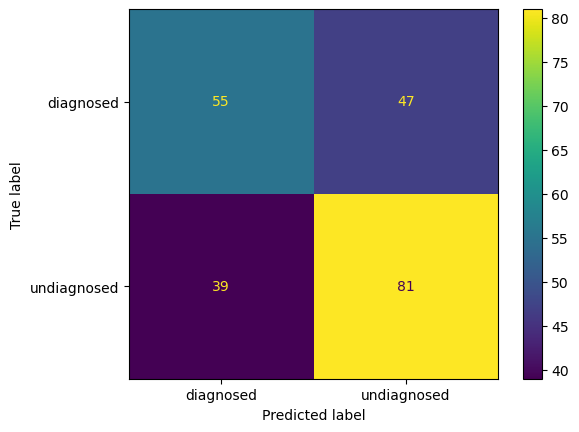

In [15]:
restbp_chol_9_mat = confusion_matrix(
    pred_restbp_chol_9["heart_disease"],  # true labels
    pred_restbp_chol_9["predicted"],  # predicted labels
    labels=knn_fit_restbp_chol_9.classes_, # specify the label for each class
)
disp_restbp_chol_9 = ConfusionMatrixDisplay(
    confusion_matrix=restbp_chol_9_mat, display_labels=knn_fit_restbp_chol_9.classes_
)
disp_restbp_chol_9.plot()

#### Relationship between Resting Blood Pressure and Max Heart Rate

We will show a pattern in the two varibles, `resting_blood_pressure` and `max_heart_rate`, by using the K nearest neighbors classification.

In [16]:
# try to see the result with n=5
X_train_restbp_maxhr = hd_train.loc[:, ["resting_blood_pressure", "max_heart_rate"]]
y = hd_train["heart_disease"]

hd_preprocessor_restbp_maxhr = make_column_transformer(
    (StandardScaler(), ["resting_blood_pressure", "max_heart_rate"]),
)
pipe_restbp_maxhr_k5 = make_pipeline(hd_preprocessor_restbp_maxhr, knn_5)
knn_fit_restbp_maxhr = pipe_restbp_maxhr_k5.fit(X_train_restbp_maxhr, y)

cv_5_df_2 = pd.DataFrame(
    cross_validate(estimator = pipe_restbp_maxhr_k5, cv=5, X=X_train_restbp_maxhr, y=y, return_train_score=True)
)
print("Mean test score (5-fold cross-validation): ", cv_5_df_2["test_score"].mean())

cv_10_df_2 = pd.DataFrame(
    cross_validate(estimator = pipe_restbp_maxhr_k5, cv=10, X=X_train_restbp_maxhr, y=y, return_train_score=True)
)
print("Mean test score (10-fold cross-validation): ", cv_10_df_2["test_score"].mean())

Mean test score (5-fold cross-validation):  0.6128282828282828
Mean test score (10-fold cross-validation):  0.6219367588932806


So, the test score with K=5 may be around 62%. Now we will look for the best K to improve our prediction by using Grid Search

In [17]:
knn = KNeighborsClassifier()
tune_pipe_restbp_maxhr = make_pipeline(hd_preprocessor_restbp_maxhr, knn)
param_grid = {"kneighborsclassifier__n_neighbors": range(1, 30)}

tune_grid_restbp_maxhr = GridSearchCV(
    estimator=tune_pipe_restbp_maxhr,
    param_grid=param_grid,
    cv=5
)
tune_grid_restbp_maxhr

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['resting_blood_pressure',
                                                                          'max_heart_rate'])])),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__n_neighbors': range(1, 30)})

We will check the cross-validation accuracy estimate and the standard error for the K values from 1 to 29.

In [18]:
accuracies_grid_restbp_maxhr = pd.DataFrame(
    tune_grid_restbp_maxhr.fit(X_train_restbp_maxhr, y).cv_results_
)

accuracies_restbp_maxhr = accuracies_grid_restbp_maxhr[["param_kneighborsclassifier__n_neighbors", "mean_test_score", "std_test_score"]
              ].assign(
                  sem_test_score = accuracies_grid_restbp_maxhr["std_test_score"] / 10**(1/2)
              ).rename(
                  columns = {"param_kneighborsclassifier__n_neighbors" : "n_neighbors"}
              ).drop(
                  columns = ["std_test_score"]
              )

accuracy_k_grid_restbp_maxhr = (
    alt.Chart(accuracies_restbp_maxhr)
    .mark_line(point=True)
    .encode(
      alt.X(alt.repeat("column"), type='quantitative'),
      alt.Y(alt.repeat("row"), type='quantitative', scale=alt.Scale(zero=False)),
    )
    .properties(width=300, height=300)
    .repeat(
      row=['mean_test_score', 'sem_test_score'],
      column=['n_neighbors']
    )
)
accuracy_k_grid_restbp_maxhr

/opt/conda/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.RepeatChart(...)

We can see K>16 shows higher test scores than K<17 with lower values of the standard error. So, we will pick up K=17 here.

In [19]:
# try to see the result with n=17
knn_17 = KNeighborsClassifier(n_neighbors=17)
knn_fit_restbp_maxhr_17 = make_pipeline(hd_preprocessor_restbp_maxhr, knn_17).fit(X_train_restbp_maxhr, y)

pred_restbp_maxhr_17 = hd_train.assign(
    predicted = knn_fit_restbp_maxhr_17.predict(hd_train.loc[:, ["resting_blood_pressure", "max_heart_rate"]])
)

# check the accuracy of the prediction by the ratio
correct_preds_restbp_maxhr_17 = pred_restbp_maxhr_17[
    pred_restbp_maxhr_17["heart_disease"] == pred_restbp_maxhr_17["predicted"]
]
print("Ratio of correct prediction: ", correct_preds_restbp_maxhr_17.shape[0] / pred_restbp_maxhr_17.shape[0])

# check the score of accuracy
pred_accuracy_restbp_maxhr_17 = knn_fit_restbp_maxhr_17.score(
    X = X_train_restbp_maxhr,
    y = y
)
print("Accuracy: ", pred_accuracy_restbp_maxhr_17)

Ratio of correct prediction:  0.7072072072072072
Accuracy:  0.7072072072072072


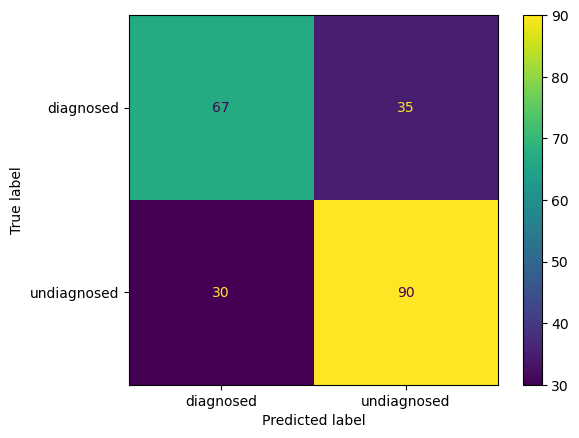

In [20]:
restbp_maxhr_17_mat = confusion_matrix(
    pred_restbp_maxhr_17["heart_disease"],  # true labels
    pred_restbp_maxhr_17["predicted"],  # predicted labels
    labels=knn_fit_restbp_maxhr_17.classes_, # specify the label for each class
)
disp_restbp_maxhr_17 = ConfusionMatrixDisplay(
    confusion_matrix=restbp_maxhr_17_mat, display_labels=knn_fit_restbp_maxhr_17.classes_
)
disp_restbp_maxhr_17.plot()

We would choose K=17 beased on the high test score and a low standard error.

#### Relationship between Cholesterol and Maximum Heart Rate Achieved

We will show a pattern in the two varibles, `cholesterol` and `max_heart_rate`, by using the K nearest neighbors classification. First, we will perform 5-fold and 10-fold cross-validation with K=5 to see the mean value of the test scores.

In [21]:
# try to see the result with n=5
X_train_chol_maxhr = hd_train.loc[:, ["cholesterol", "max_heart_rate"]]
y = hd_train["heart_disease"]

hd_preprocessor_chol_maxhr = make_column_transformer(
    (StandardScaler(), ["cholesterol", "max_heart_rate"]),
)
pipe_chol_maxhr_k5 = make_pipeline(hd_preprocessor_chol_maxhr, knn_5)
knn_fit_chol_maxhr = pipe_chol_maxhr_k5.fit(X_train_chol_maxhr, y)

cv_5_df_3 = pd.DataFrame(
    cross_validate(estimator = pipe_chol_maxhr_k5, cv=5, X=X_train_chol_maxhr, y=y, return_train_score=True)
)
print("Mean test score (5-fold cross-validation): ", cv_5_df_3["test_score"].mean())

cv_10_df_3 = pd.DataFrame(
    cross_validate(estimator = pipe_chol_maxhr_k5, cv=10, X=X_train_chol_maxhr, y=y, return_train_score=True)
)
print("Mean test score (10-fold cross-validation): ", cv_10_df_3["test_score"].mean())

Mean test score (5-fold cross-validation):  0.6393939393939394
Mean test score (10-fold cross-validation):  0.6480237154150197


So, the test score with K=5 may be around 64%. Now we will look for the best K to improve our prediction. Now we will look for a best K to improve our prediction.

In [22]:
knn = KNeighborsClassifier()
tune_pipe_chol_maxhr = make_pipeline(hd_preprocessor_chol_maxhr, knn)
param_grid = {"kneighborsclassifier__n_neighbors": range(1, 30)}

tune_grid_chol_maxhr = GridSearchCV(
    estimator=tune_pipe_chol_maxhr,
    param_grid=param_grid,
    cv=5
)
tune_grid_chol_maxhr

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['cholesterol',
                                                                          'max_heart_rate'])])),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__n_neighbors': range(1, 30)})

We will check the cross-validation accuracy estimate and the standard error for the K values from 1 to 29.

In [23]:
accuracies_grid_chol_maxhr = pd.DataFrame(
    tune_grid_chol_maxhr
    .fit(X_train_chol_maxhr, y).cv_results_
)

accuracies_chol_maxhr = accuracies_grid_chol_maxhr[["param_kneighborsclassifier__n_neighbors", "mean_test_score", "std_test_score"]
              ].assign(
                  sem_test_score = accuracies_grid_chol_maxhr["std_test_score"] / 10**(1/2)
              ).rename(
                  columns = {"param_kneighborsclassifier__n_neighbors" : "n_neighbors"}
              ).drop(
                  columns = ["std_test_score"]
              )

accuracy_k_grid_chol_maxhr = (
    alt.Chart(accuracies_chol_maxhr)
    .mark_line(point=True)
    .encode(
      alt.X(alt.repeat("column"), type='quantitative'),
      alt.Y(alt.repeat("row"), type='quantitative', scale=alt.Scale(zero=False)),
    )
    .properties(width=300, height=300)
    .repeat(
      row=['mean_test_score', 'sem_test_score'],
      column=['n_neighbors']
    )
)
accuracy_k_grid_chol_maxhr

/opt/conda/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.RepeatChart(...)

We can see K>15 shows higher test scores than K<16 with lower values of the standard error. So, we will pick up K=20 here.

In [24]:
# try to see the result with n=20
knn_20 = KNeighborsClassifier(n_neighbors=20)
knn_fit_chol_maxhr_20 = make_pipeline(hd_preprocessor_chol_maxhr, knn_20).fit(X_train_chol_maxhr, y)

pred_chol_maxhr_20 = hd_train.assign(
    predicted = knn_fit_chol_maxhr_20.predict(X_train_chol_maxhr)
)

# check the accuracy of the prediction by the ratio
correct_preds_chol_maxhr_20 = pred_chol_maxhr_20[
    pred_chol_maxhr_20["heart_disease"] == pred_chol_maxhr_20["predicted"]
]
print("Ratio of correct prediction: ", correct_preds_chol_maxhr_20.shape[0] / pred_chol_maxhr_20.shape[0])

# check the score of accuracy
pred_accuracy_chol_maxhr_20 = knn_fit_chol_maxhr_20.score(
    X = X_train_chol_maxhr,
    y = y
)
print("Accuracy: ", pred_accuracy_chol_maxhr_20)

Ratio of correct prediction:  0.7072072072072072
Accuracy:  0.7072072072072072


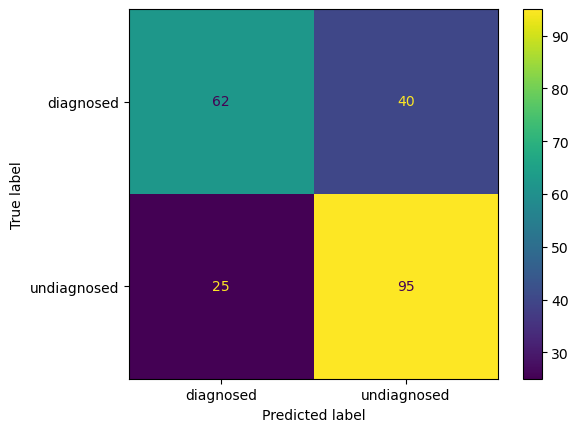

In [25]:
chol_maxhr_20_mat = confusion_matrix(
    pred_chol_maxhr_20["heart_disease"],  # true labels
    pred_chol_maxhr_20["predicted"],  # predicted labels
    labels=knn_fit_chol_maxhr_20.classes_, # specify the label for each class
)
disp_chol_maxhr_20 = ConfusionMatrixDisplay(
    confusion_matrix=chol_maxhr_20_mat, display_labels=knn_fit_chol_maxhr_20.classes_
)
disp_chol_maxhr_20.plot()

We would choose K=20 based on the high test score and a low standard error.